# RL coursework, part IV (30 pts in total)

---

**Name:** Benoît Coutière

**SN:**

---

**Due date:** *April 10th, 2025*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

## Section A: Multi-step + offpolicy in practice [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency.

In [2]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [3]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi / mu

  for t in reversed(range(T)):
      if t == T - 1:
          G[t] = r[t] + d[t] * v[t + 1]
      else:
          G[t] = r[t] + d[t] * ((1 - l) * v[t + 1] + l * G[t + 1])
      G[t] *= np.prod(rho[t:])

  v = v[:-1]
  return (1 - l) * v + l * G

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi/mu
  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
    G[t] *= rho[t]

  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G



def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi/mu
  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
    G[t] *= rho[t]
    G[t] -= (rho[t] - 1) * v[t]

  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """

  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi/mu
  for t in reversed(range(T)):
    lambda_t = l * min(1, 1/rho[t])
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - lambda_t)*v[t + 1] + lambda_t*G[t + 1])
    G[t] *= rho[t]
    G[t] -= (rho[t] - 1) * v[t]

  v = v[:-1]
  return (1 - l)*v + l*G

In [4]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...

  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right,
  rewards[-1] = np.sum(actions)  # extra final reward for going right

  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities

  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[      20.37  16059644.257      174.971        5.89         1.772]


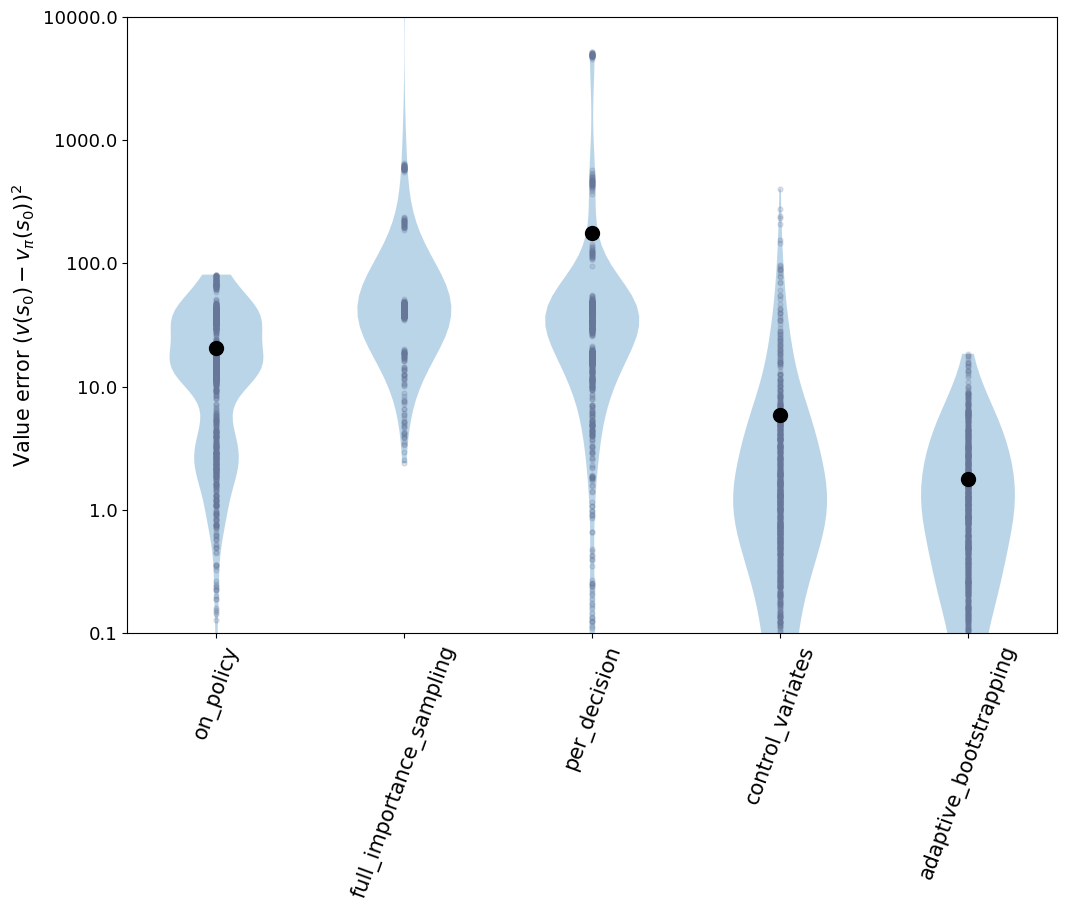

In [5]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

**The full importance sampling** has the higher mean squared value error. Compared to the simple in_policy algorithm, the full_importance_sampling one could give too important weights to returns that are common under the target policy but rare under the behavior policy or too small weights rare under the target policy and common under the behavior policy, which will therefore increase the variance. Mathematically, this is translated by the fact that the rato pi/mu associated with the return is either largely greater than one (in the case where we pick an event that is common under the target policy but rare under the behavior policy) : the return will therefore have a greater importance than it should have, which will increase the variance and imply a greater value error. In the case where he rato pi/mu associated with the return is either largely smaller than one (in the case where we pick an event that is common under the behavior policy but rare under the target policy) : the return will therefore have a smaller importance than it should have, which will increase the variance and imply a greater value error.

**The per decision method** has the second higher mean squared value error. The variance of this method is reduced compared to the full importance sampling one, because each of the importance sampling ratio is only applied once to r[t] which limits the value of potential errors, whereas in the full importance sampling method, all the previous rhos are applied to r[t], which leads to greater variance. In this method, each previous action is considered independant from the later ones.

**The control variates method** has the third higher squared value error. This method consists in adding a term $((ρ[t] - 1) * v[t])$ to the return G[t] obtained with the per decision method. This additional term has an expectation of 0 but varies along with $ρ[t]*(r[t] + γ[t]*((1 - λ)*v[t + 1] + λ*G[t + 1]))$, which allows to reduce variance compared to the previous per decision method, without changing the expectation. We can notice that this method is the first one to perform better than the on-policy method.

**The adaptative bootstraping method** has the fourth higher squared value error. This method improves the control variates approach by introducing an adaptive value for λ, which is now equal to λ · min(1, 1/ρ). This adjustment ensures that λ · ρ $\leq$ 1, thereby preventing excessively large values that would otherwise increase variance. By doing so, the method takes into account situations where actions from the behavior policy are rare while actions from the target policy are common (scenarios that typically contribute disproportionately to the variance of the estimates due to insufficient exploratio). Consequently, this adaptive approach results in lower variance.



### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

The reason not to choose the best return according to this ranking would be to avoid the deadly triad. Here, the three conditions of the deadly triad are united : approximated value fonction, bootstrapping and off-policy learning. Even though the adaptative bootstrapping allow to mitigate the risk, there is still a probablilyty that the adaptative bootstrapping method diverges and has an infinite variance if we use it to generate too many return samples. For instance, if we have too much rare estimates, we will end up by bootstrapping a lot which would increase our chances of our algorithm diverging.

## Section B: Potential different algorithms/updates [19 points total]
 Consider a MDP $M = (\mathbb{S}, \mathbb{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

i)

We define a Bellman operator T for an action-value function $q:\mathcal{S}\times\mathcal{A}\to\mathbb{R}$ as follows:

$(Tq)(s,a) = \mathbb{E}\Bigl[ r(s,a) + \gamma\, r(s',a') + \gamma^2\,\max_{a'} q(s'',a') \,\Bigl|\, S_t=s, A_t=a \Bigr]$

$(Tq)(s,a) = r(s,a) + \mathbb{E}_{s',a'}\Bigl[\gamma\, r(s',a')\Bigl] + \mathbb{E}_{s',a', s''}\Bigl[\gamma^2\,\max_{b} q(s'',b) \Bigr]$

Therefore :

$(Tq_1)(s,a) - (Tq_2)(s,a) = r(s,a) + \mathbb{E}_{s',a'}\Bigl[\gamma\, r(s',a')\Bigl] + \mathbb{E}_{s',a', s''}\Bigl[\gamma^2\,\max_{b} q_1(s'',b) \Bigr] - r(s,a) - \mathbb{E}_{s',a'}\Bigl[\gamma\, r(s',a')\Bigl] - \mathbb{E}_{s',a', s''}\Bigl[\gamma^2\,\max_{b} q_2(s'',b) \Bigr]$

$==> (Tq_1)(s,a) - (Tq_2)(s,a) = \mathbb{E}_{s',a', s''}\Bigl[\gamma^2\,\max_{b} q_1(s'',b) \Bigr] - \mathbb{E}_{s',a', s''}\Bigl[\gamma^2\,\max_{b} q_2(s'',b) \Bigr]$

$==> |(Tq_1)(s,a) - (Tq_2)(s,a)| = \gamma^2|\mathbb{E}_{s',a', s''}\Bigl[\max_{b} q_1(s'',b) - \max_{b} q_2(s'',b) \Bigr]|$, since $q_1$ and $q_2$ are independant.

$==> |(Tq_1)(s,a) - (Tq_2)(s,a)| \leq \gamma^2|\mathbb{E}_{s',a', s''}\Bigl[\max_{b} q_1(s'',b) - q_2(s'',b) \Bigr]|$

$==> |(Tq_1)(s,a) - (Tq_2)(s,a)| \leq \gamma^2|\Bigl[\max_{b, s''} q_1(s'',b) - q_2(s'',b) \Bigr]|$

$==> ||(Tq_1)(s,a) - (Tq_2)(s,a)||_{∞} \leq \gamma^2||q_1 - q_2 ||_{∞}$

Therefore, since $γ < 1$ (and $γ^2 < 1$), T is a $γ^2$ contraction. According to the Banach fixed point theorem, T has a unique fixed point $q_{\mu}$ and converges towards this fixed point.


ii)

We demonstrated that the previous process converged towards $q_{\mu}$. For this algorithm to converge towards the optimal $q_{*}$, the behavior policy would have to be Greedy in the Limit with Infinite Exploration, and the Robbins-Monro conditions are satisfied.

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathbb{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points).
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$ (a and b)? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

*Answer here:*

i) a.

Here, since $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$, we have $\frac{\pi(a|s)}{\mu(a|s)}$ = 1 $\forall s,a \in \mathbb{A} \times \mathbb{S}$. Thereofore, we have $\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$, which is the same as in question 2.1. Hence, we already proved that updating a tabular action value function with this TD error converge to the optimal value function $q_*$

i) b.

We define a Bellman operator T for an action-value function $q:\mathcal{S}\times\mathcal{A}\to\mathbb{R}$ as follows:

$(Tq)(s,a) = \mathbb{E}\Bigl[ r(s,a) + \gamma'\, r(s',a') + \gamma'^2\,\max_{a'} q(s'',a') \,\Bigl|\, S_t=s, A_t=a \Bigr]$, with $\gamma' = \gamma*\frac{π(a|s)}{μ(a|s)}, \forall s,a \in \mathbb{A} \times \mathbb{S}$

$(Tq)(s,a) = r(s,a) + \mathbb{E}_{s',a'}\Bigl[\gamma'\, r(s',a')\Bigl] + \mathbb{E}_{s',a', s''}\Bigl[\gamma'^2\,\max_{b} q(s'',b) \Bigr]$

### If a $\neq a^*$ :

$\gamma' = 0$, and $(Tq)(s,a) = r(s,a)$

Thus $(Tq_1)(s,a) - (Tq_2)(s,a) = r(s,a) - r(s,a) = 0$, T is a 0 contarction and according to the Banach fixed point theorem, T converges towards a fixed point $q_{fp}$ which is equal to $q*$ if the policy is GLIE and if the Robbins-Monro conditions are satisfied.

### If a $= a^*$ :

$\gamma' = \frac{1}{\frac{1}{|\mathbb{A}|}}*\gamma$ = $|\mathbb{A}|*\gamma$

$(Tq_1)(s,a) - (Tq_2)(s,a) = r(s,a) + \mathbb{E}_{s',a'}\Bigl[\gamma'\, r(s',a')\Bigl] + \mathbb{E}_{s',a', s''}\Bigl[\gamma'^2\,\max_{b} q_1(s'',b) \Bigr] - r(s,a) - \mathbb{E}_{s',a'}\Bigl[\gamma'\, r(s',a')\Bigl] - \mathbb{E}_{s',a', s''}\Bigl[\gamma'^2\,\max_{b} q_2(s'',b) \Bigr]$

$==> (Tq_1)(s,a) - (Tq_2)(s,a) = \mathbb{E}_{s',a', s''}\Bigl[\gamma'^2\,\max_{b} q_1(s'',b) \Bigr] - \mathbb{E}_{s',a', s''}\Bigl[\gamma'^2\,\max_{b} q_2(s'',b) \Bigr]$

$==> |(Tq_1)(s,a) - (Tq_2)(s,a)| = \gamma'^2|\mathbb{E}_{s',a', s''}\Bigl[\max_{b} q_1(s'',b) - \max_{b} q_2(s'',b) \Bigr]|$, since $q_1$ and $q_2$ are independant.

$==> |(Tq_1)(s,a) - (Tq_2)(s,a)| \leq \gamma'^2|\mathbb{E}_{s',a', s''}\Bigl[\max_{b} q_1(s'',b) - q_2(s'',b) \Bigr]|$

$==> |(Tq_1)(s,a) - (Tq_2)(s,a)| \leq \gamma'^2|\Bigl[\max_{b, s''} q_1(s'',b) - q_2(s'',b) \Bigr]|$

$==> ||(Tq_1)(s,a) - (Tq_2)(s,a)||_{∞} \leq \gamma'^2||q_1 - q_2 ||_{∞}\\
$

Therefore, if $\gamma'^2 < 1$ ie if $\gamma < \frac{1}{|\mathbb{A}|}$, T is a $γ'^2$ contraction. According to the Banach fixed point theorem, T has a unique fixed point $q_{\mu}$ and converges towards this fixed point, which is equal to $q*$ if the policy is GLIE and if the Robbins-Monro conditions are satisfied.

To sum-up, case b) converges towaeds $q*$ if and only if the policy is GLIE, the Robbins-Monro conditions are satisfied and we have $\gamma < \frac{1}{|\mathbb{A}|}$.

ii) a.

Again, since $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$, we have $\frac{\pi(a|s)}{\mu(a|s)}$ = 1 $\forall s,a \in \mathbb{A} \times \mathbb{S}$. Thereofore, we have $\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$, which is the same as in question 2.1. Hence, the variance is the same.

ii) b.

Let's write $X = r(S_{t+1},A_{t+1}) + \gamma\, \max_{a} q(S_{t+2},a)$ and $Y = \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}X$

Here, the behaviour policy is uniform, so for any state s and action a we have
$\mu(a|s) = \frac{1}{|\mathbb{A}|}$

The target policy $\pi$ is greedy, so that

$\pi(a|s) =
\begin{cases}
1, & \text{if } a = a^* \quad (\text{greedy action}),\\[1mm]
0, & \text{otherwise.}
\end{cases}$

Thus, the importance sampling ratio becomes
$
\frac{\pi(a|s)}{\mu(a|s)} =
\begin{cases}
|\mathbb{A}|, & \text{if } a = a^*,\\[1mm]
0, & \text{otherwise.}
\end{cases}$

In other words, the random variable Y is given by
$Y =
\begin{cases}
|\mathbb{A}|\, X, & \text{with probability } \frac{1}{|\mathbb{A}|},\\[1mm]
0, & \text{with probability } 1 - \frac{1}{|\mathbb{A}|}\,.
\end{cases}$

Therefore : $
\mathbb{E}[Y] = |\mathbb{A}|\, \mathbb{E}[X] \cdot \frac{1}{|\mathbb{A}|} + 0 \cdot \left(1 - \frac{1}{|\mathbb{A}|}\right) = \mathbb{E}[X]\,.$

Thus, Var(Y)-Var(X) = $\mathbb{E}[Y^2] - \mathbb{E}[Y]^2 - \mathbb{E}[X^2] + \mathbb{E}[X]^2 = \mathbb{E}[Y^2] - \mathbb{E}[X^2]$

We notice that $Y^2 =
\begin{cases}
|\mathbb{A}|^2\, X^2, & \text{with probability } \frac{1}{|\mathbb{A}|},\\[1mm]
0, & \text{with probability } 1 - \frac{1}{|\mathbb{A}|}\,,
\end{cases}$

It gives us :
$
\mathbb{E}[Y^2] = |\mathbb{A}|^2\, \mathbb{E}[X^2] \cdot \frac{1}{|\mathbb{A}|} + 0 \cdot \left(1 - \frac{1}{|\mathbb{A}|}\right)
= |\mathbb{A}|\, \mathbb{E}[X^2]\,.
$

Finally, Var(Y)-Var(X) = $\mathbb{E}[Y^2] - \mathbb{E}[X^2] = (|\mathbb{A}|-1)Var(X) \geq Var(X)$ since $|\mathbb{A}|>1$. Therefore, the varaiance of the expression of 2.2.b is higher than the varaince of the expression of 2.1.



iii)

When $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$, we are on-policy. Consequently, we wouldn't find any better behavior policy than this one. We are going to show this mathematically :

Let's imagine that there exist a behavior policy μ which would have a lower variance than the one obtained in case a.

Let's write $X = r(S_{t+1},A_{t+1}) + \gamma\, \max_{a} q(S_{t+2},a)$ and $Y = \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}X$


Since $\pi$ is greedy, the importance sampling ratio is
$
\frac{\pi(a|s)}{\mu(a|s)} =
\begin{cases}
\frac{1}{μ(a^*|s)}, & \text{if } a = a^*,\\[1mm]
0, & \text{otherwise.}
\end{cases}$

In other words, the random variable Y is given by
$Y =
\begin{cases}
\frac{1}{μ(a^*|s)}, X, & \text{with probability } μ(a^*|s),\\[1mm]
0, & \text{with probability } 1 - μ(a^*|s)\,.
\end{cases}$

Which implies that :

$Y^2 =
\begin{cases}
\frac{1}{μ(a^*|s)^2}, X^2, & \text{with probability } μ(a^*|s),\\[1mm]
0, & \text{with probability } 1 - μ(a^*|s)\,.
\end{cases}$

We have : $
\mathbb{E}[Y] = \frac{1}{μ(a^*|s)} \mathbb{E}[X] \cdot μ(a^*|s) + 0 \cdot \left(1 - μ(a^*|s)\right) = \mathbb{E}[X]\,.$

In addition, we have : $
\mathbb{E}[Y^2] = μ(a^*|s) \mathbb{E}[X^2] \cdot \frac{1}{μ(a^*|s)^2} + 0 \cdot \left(1 - μ(a^*|s)\right) = \mathbb{E}[X^2] \cdot \frac{1}{μ(a^*|s)}$

Finally, $Var(X) > Var(Y)$

$==>  \mathbb{E}[X^2] - \mathbb{E}[X]^2 > \mathbb{E}[Y^2] - \mathbb{E}[Y]^2$

$==>  \mathbb{E}[X^2] > \mathbb{E}[Y^2]$

$==>  \mathbb{E}[X^2] > \mathbb{E}[X^2] \cdot \frac{1}{μ(a^*|s)}$

$==>  μ(a^*|s) > 1$

Since μ is a probability distribution, the previous equation is absurd and there is no such μ which would have a lower variance than the one obtained in case a.
